In [55]:
import os
import glob
import shutil

from ciao_contrib.cda.data import download_chandra_obsids
import ciao_contrib.runtool as rt

%matplotlib inline

In [32]:
#os.mkdir('data')
#os.chdir('data')
# List of ObsIDs manually from Herman
obsids = [24594, 24946, 24947, 24595, 24948, 24949, 24596, 24950, 24951]
download_chandra_obsids(obsids)

[True, True, True, True, True, True, True, True, True]

Technically, there is no need to download everything (evt1 files might do), but I'm not sure what exactly ape needs and it's just faster to download everything then to figure that out if I only have a few (not too big) ObsIDs. It;s just over a GB of data, but I can delete most of it after I run ape below.

In [4]:
obsids = [int(s) for s in glob.glob('[0-9]*')]
obsids.sort()

Techically, there is no need to run repro here. 

In [8]:
for f in glob.glob('[0-9]*/*/*evt1*'):
    rt.acis_process_events.punlearn()
    rt.acis_process_events(infile=f, 
                           outfile=os.path.join(os.path.dirname(f), 'evt1_notgain.fits'),
                           apply_cti=True, apply_tgain=False,
                           ctifile="CALDB",
                           doevtgrade=True, calculate_pi=True, stop='none',
                           clobber=True)

In [12]:
glob.glob('[0-9]*/*/*evt1_notgain.fits')

['24948/secondary/evt1_notgain.fits',
 '24946/secondary/evt1_notgain.fits',
 '24947/secondary/evt1_notgain.fits',
 '24949/secondary/evt1_notgain.fits',
 '24594/secondary/evt1_notgain.fits',
 '24595/secondary/evt1_notgain.fits',
 '24950/secondary/evt1_notgain.fits',
 '24951/secondary/evt1_notgain.fits',
 '24596/secondary/evt1_notgain.fits']

Now, we copy the reprocessed evt1 files that we want to keep and delete the rest of the data to save space.

In [19]:
for f in glob.glob('[0-9]*/*/*evt1_notgain.fits'):
    shutil.copy(f, os.path.dirname(os.path.dirname(f)) + '_evt1_notgain.fits')

In [26]:
for f in glob.glob('*'):
    if os.path.isdir(f):
        shutil.rmtree(f)

In [30]:
glob.glob('[0-9]*/*/*evt2*')[4]

'24594/primary/acisf24594N001_evt2.fits.gz'

Key points for reprocessing:

  - `apply_tgain=False` in `acis_process_events` because it is the gain that we want to determine, so do not use the numbers that's currently in the CALDB
  - `osipfile="none"` in `tg_resolve_events`. The OSIP files cut on energy and assume that the energy is correct, i.e. that it is already corrected for the gain. Since we do not do that, using a OGIP can cut-off the distribution that we are looking for because an events "energy" as assigned by `acis_process_events` is outside of the OGIP range.

In [134]:
# in production, these columns are sufficient
eventdef = 'tg_d,chipx,chipy,ccd_id,pha,tg_lam,tg_m,tg_part'
# but in the development phase I accept later tables and keep a few more columns to help debugging
eventdef = 'tg_r,tg_d,chipx,chipy,x,y,ccd_id,pha,grade,node_id,tg_lam,tg_m,tg_mlam,tg_part'

for obsid in obsids:
    evt1 = glob.glob(f"{obsid}/secondary/*evt1.fits*")[0]
    asol = glob.glob(f"{obsid}/primary/*asol*")[0]
    flt1 = glob.glob(f"{obsid}/secondary/*flt1.fits*")[0]
    
    rt.acis_process_events.punlearn()
    rt.acis_process_events(infile=evt1, 
                           outfile=f'{obsid}/{obsid}_evt1_notgain.fits',
                           apply_cti=True, apply_tgain=False,
                           ctifile="CALDB", mtlfile=f"{obsid}/secondary/*mtl*",
                           acaofffile=f"{obsid}/primary/*asol*",
                           doevtgrade=True, calculate_pi=True, stop='none',
                           clobber=True)

    rt.tgdetect2.punlearn()
    rt.tgdetect2(infile=evt1, outfile=f'{obsid}/{obsid}_src1a.fits', clobber=True)


    rt.tg_create_mask.punlearn()
    rt.tg_create_mask(infile=evt1, input_pos_tab=f'{obsid}/{obsid}_src1a.fits',
                      outfile=f'{obsid}/{obsid}_evt1_L1a.fits', clobber=True)

    rt.tg_resolve_events.punlearn()
    rt.tg_resolve_events(infile=f'{obsid}/{obsid}_evt1_notgain.fits', 
                         outfile=f'{obsid}/{obsid}_evt1a.fits',
                         regionfile=f'{obsid}/{obsid}_evt1_L1a.fits',
                         acaofffile=asol, 
                         osipfile='none',
                         clobber=True)

    # 1. Apply grade/status filters (dmcopy)
    rt.dmcopy.punlearn() 
    rt.dmcopy(infile=f"{obsid}/{obsid}_evt1a.fits[EVENTS][grade=0,2,3,4,6,status=0]",
              outfile=f"{obsid}/{obsid}_flt_evt1a.fits", clobber=True)
    rt.dmappend(infile=f"{obsid}/{obsid}_evt1a.fits[region][subspace -time]",
               outfile=f"{obsid}/{obsid}_flt_evt1a.fits")
    # 2. Apply GTI filters (dmcopy)
    rt.dmcopy(infile=f"{obsid}/{obsid}_flt_evt1a.fits[EVENTS][@{flt1}][cols {eventdef}]",
              outfile=f"{obsid}_evt2_nogain.fits",
              opt="", clobber=True)
    rt.dmappend(infile=f"{obsid}/{obsid}_flt_evt1a.fits[region][subspace -time]",
                outfile=f"{obsid}_evt2_nogain.fits")


In [147]:
ls

24594/                   24946_evt1_notgain.fits  24949/
24594_evt1_notgain.fits  24946_evt2_nogain.fits   24949_evt1_notgain.fits
24594_evt2_nogain.fits   24947/                   24949_evt2_nogain.fits
24595/                   24947_evt1_notgain.fits  24950/
24595_evt1_notgain.fits  24947_evt2_nogain.fits   24950_evt1_notgain.fits
24595_evt2_nogain.fits   24948/                   24950_evt2_nogain.fits
24596/                   24948_evt1_notgain.fits  24951/
24596_evt1_notgain.fits  24948_evt2_nogain.fits   24951_evt1_notgain.fits
24596_evt2_nogain.fits   24948_evt_notgain.fits   24951_evt2_nogain.fits
24946/                   24948_src1a.fits


In [150]:
from astropy.table import Table, vstack

In [148]:
tabs = [Table.read(f, hdu=1) for f in glob.glob('*evt2_nogain.fits')]

In [153]:
tab = vstack(tabs, metadata_conflicts='silent')

In [413]:
tab

<Table length=1580040>
     tg_r            tg_d      chipx chipy ...  tg_m   tg_mlam    tg_part
     deg             deg        pix   pix  ...         Angstrom          
   float32         float32     int16 int16 ... int16   float32     int16 
-------------- --------------- ----- ----- ... ----- ------------ -------
  8.350955e-06     -0.00630837    42   354 ...    -- 0.0014447138       3
-0.00031292997   -0.0026487873    40   377 ...     0          0.0       0
   0.035170916   -0.0016648945   263   383 ...    --    6.0845623       3
    0.03835218  -0.00023016901   283   392 ...     1      6.63492       3
    0.13382657  -0.00015174944   883   392 ...     3    23.151953       3
 0.00016244367 -0.000102405786    43   393 ...     0          0.0       0
-0.00015628991   0.00037469465    41   396 ...     0          0.0       0
    0.14988369     0.017365089   984   502 ...    --    25.929823       3
   -0.03539297    3.814499e-05   864   394 ...    -1   -6.1229777       3
           ...             ...   ...   ... ...   ...          ...     ...
   -0.27773488    0.0034415163   366   189 ...   -52   -48.047897       3
  -0.040818837   0.00046894007   812   169 ...    -1    -7.061651       3
           nan             nan   250   166 ...    --          nan      99
           nan             nan   163   167 ...    --          nan      99
           nan             nan    24   169 ...    --          nan      99
           nan             nan    37   179 ...    --          nan      99
           nan             nan   171    32 ...    --          nan      99
           nan             nan   425    54 ...    --          nan      99
           nan             nan   814   167 ...    --          nan      99
           nan             nan   441   220 ...    --          nan      99

In [137]:
import matplotlib.pyplot as plt

In [541]:
tab7 = tab[(tab['ccd_id'] == 7) & (tab['tg_part']==3)] # & (tab['tg_m'] < 2)& (tab['tg_m'] > 0)]

In [542]:
len(tab7)
tab7=tab7[:25000]

647974

Text(0.5, 1.0, 'ccd_id=7')

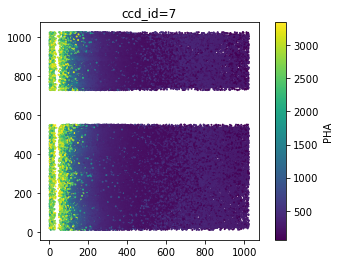

In [547]:
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'})
tab7clean = tab7[np.isfinite(tab7['tg_lam']) & (tab7['tg_part']==3) & np.isin(tab7['tg_m'], [-3, -2, -1, 1, 2, 3])]
out = ax.scatter(tab7clean['chipx'], tab7clean['chipy'], c=tab7clean['pha'], s=1)
cbar = plt.colorbar(out)
cbar.set_label('PHA')
ax.set_title('ccd_id=7')

Text(0, 0.5, 'PHA')

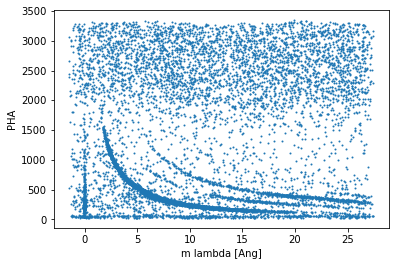

In [572]:
plt.scatter(tab7['tg_mlam'][:15000], tab7['pha'][:15000], s=1)
#plt.scatter(tab7['tg_mlam'], tab7['pha'] / (12.4 / tab7['tg_mlam']), c=tab7['tg_m'], s=1)
#plt.colorbar()
#plt.xlim(0, 0.005)
plt.xlabel('m lambda [Ang]')
plt.ylabel('PHA')

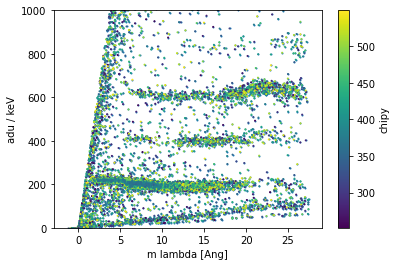

In [575]:
plt.scatter(tab7['tg_mlam'][:20000], tab7['pha'][:20000] / (12.4 / tab7['tg_mlam'][:20000]), s=1)
plt.scatter(tab7['tg_mlam'][:20000], tab7['pha'][:20000] / (12.4 / tab7['tg_mlam'][:20000]), c=tab7['chipy'][:20000], s=1)
cbar = plt.colorbar()
plt.ylim(0, 1000)
#plt.xlim(0, 8)
plt.xlabel('m lambda [Ang]')
plt.ylabel('adu / keV')
cbar.set_label('chipy')

In [80]:
import astropy.units as u

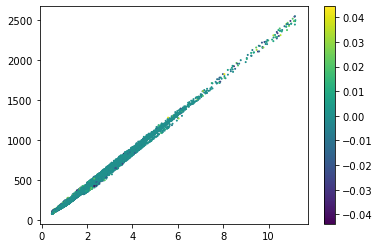

In [111]:
en = tab7['tg_lam'].to(u.keV, equivalencies=u.spectral())
plt.scatter(en, tab7['pha'].data,
            c=tab7['tg_d'], s=1)
plt.colorbar()

In [165]:
np.nanmean(en / tab7['pha'])

<Quantity 0.0049262 keV / adu>

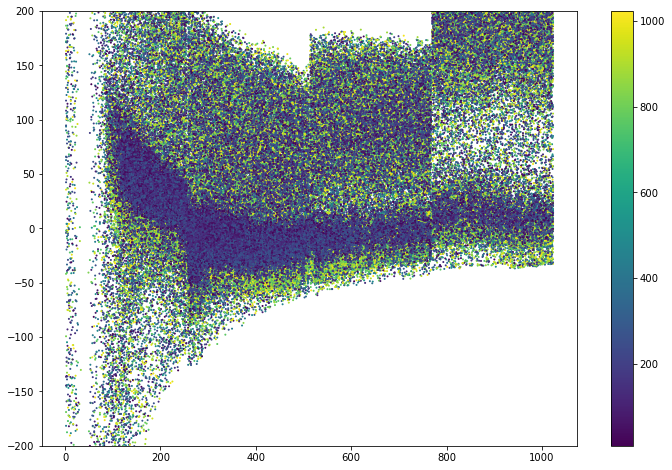

In [540]:
fig, ax = plt.subplots(figsize=(12, 8))
en = tab7['tg_lam'].to(u.keV, equivalencies=u.spectral())
im = ax.scatter(tab7['chipx'], tab7['pha'].data - en.data * np.nanmean(tab7['pha'].data / en.data),
            c=tab7['chipy'], s=1)
#ax.set_xlim(0, 7)
ax.set_ylim(-200, 200)
plt.colorbar(im)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
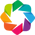

In [161]:
import pandas as pd
import numpy as np
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

In [411]:
ev_per_PHA = 5 * u.eV / u.adu

tabclean = tab[np.isfinite(tab['tg_lam']) & (tab['tg_part']==3) & np.isin(tab['tg_m'], [-3, -2, -1, 1, 2, 3])]
en = tabclean['tg_lam'].to(u.eV, equivalencies=u.spectral())
tabclean['dPHA'] = tabclean['pha'] - en / ev_per_PHA
tabclean['energy'] = en

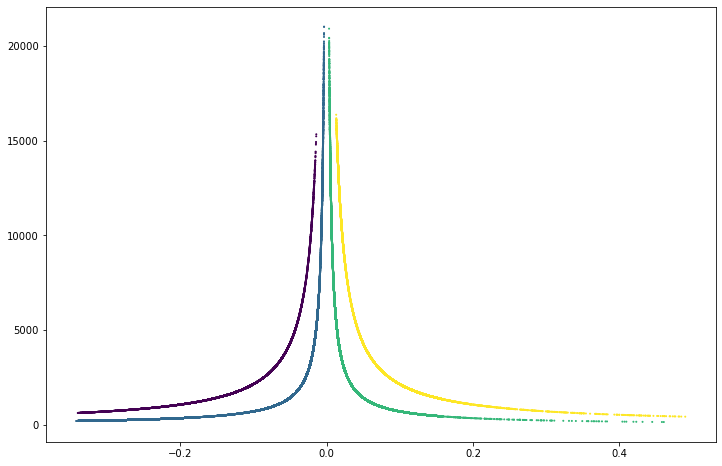

In [376]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(tabclean['tg_r'], tabclean['energy'], c=tabclean['tg_m'], s=1)

In [522]:
tilexbin = np.arange(0, 1025, 32)
tileybin = np.arange(0, 1025, 128)
enbins = np.arange(.5, 7, .25)

tabclean['tilex'] = np.digitize(tabclean['chipx'], tilexbin)
tabclean['tiley'] = np.digitize(tabclean['chipy'], tileybin)
tabclean['enbin'] = np.digitize(tabclean['energy']/1000, enbins)

In [523]:
# drop some columns for convenience
t = tabclean['ccd_id', 'tilex', 'tiley', 'dPHA', 'energy', 'tg_m', 'enbin']

In [524]:
np.bincount(t['ccd_id'])

array([     0,      0,      0,      0,      0,  38657, 319077, 397607,
          994,    238])

In [525]:
t7 = t[t['ccd_id']==7]
t7.remove_column('ccd_id')

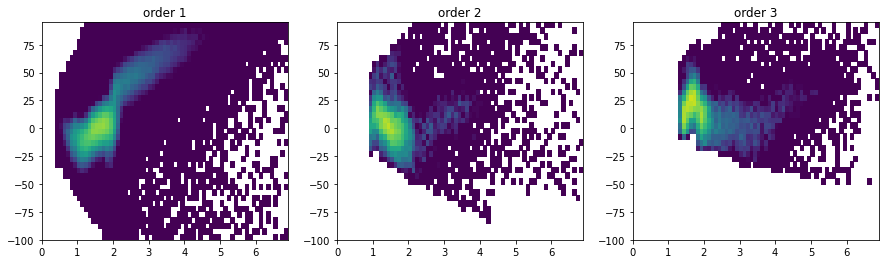

In [513]:
import matplotlib.colors as colors

fig, axes = plt.subplots(figsize=(15, 4), ncols=3)
for ax, o in zip(axes, [1, 2, 3]):
    ind = t7['tg_m'] == o
    im = ax.hist2d(t7['energy'][ind]/1e3, t7['dPHA'][ind], bins=[np.arange(0, 7, .1), np.arange(-100, 100, 5)],
                  density=True, norm=colors.LogNorm(vmin=.001, vmax=.05), )
    ax.set_title(f'order {o}')

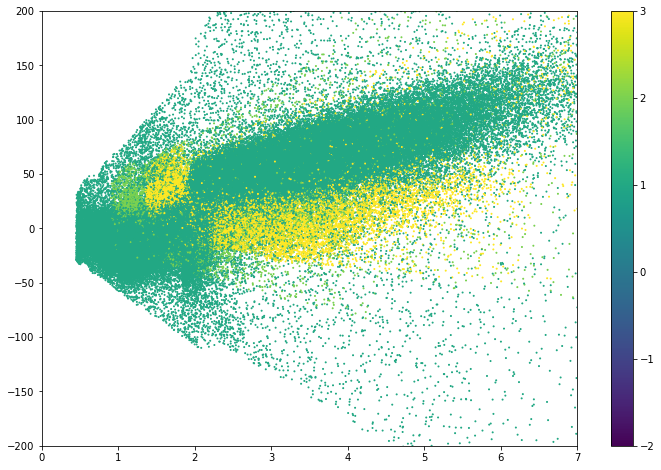

In [514]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.scatter(t7['energy']/1e3, t7['dPHA'], c=t7['tg_m'], s=1)
ax.set_xlim(0, 7)
ax.set_ylim(-200, 200)
plt.colorbar(im)

In [526]:
tp = t7.to_pandas()

In [527]:
out = tp.drop(columns=['energy', 'tg_m']).groupby(['tilex', 'tiley', 'enbin']).aggregate(np.mean)

In [528]:
dPHA7 = np.nan * np.empty((len(tilexbin) -1, len(tileybin)-1, len(enbins)-1))

/Users/hamogu/anaconda3/envs/ciao/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [529]:
enbins

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75,
       6.  , 6.25, 6.5 , 6.75])

In [530]:
for i in range(len(tilexbin)):
    for j in range(len(tileybin)):
        for k in range(len(enbins)):
            try:
                dPHA7[i-1, j-1, k-1] = out.loc[i, j, k]
            except KeyError:
                dPHA7[i-1, j-1, k-1] = np.nan

In [531]:
ds = hv.Dataset((enbins, 
                 np.arange(64, 1024, 128), 
                 np.arange(16, 1024, 32), 
                 dPHA7), kdims=['enbin', 'tiley','tilex'], vdims=['dPHA'])

In [536]:
ds.to(hv.Image, ['tilex', 'tiley']).opts(colorbar=True, aspect=1)

:HoloMap   [enbin]
   :Image   [tilex,tiley]   (dPHA)

In [538]:
ds.select(enbin=(2,3)).to(hv.Image, ['tilex', 'tiley']).opts(colorbar=True, aspect='equal')

:HoloMap   [enbin]
   :Image   [tilex,tiley]   (dPHA)

In [460]:
hv.help(hv.HoloMap)

Parameters of 'HoloMap'

Parameters changed from their default values are marked in red.
Soft bound values are marked in cyan.
C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None

Name            Value             Type     Bounds   Mode 

cdims       OrderedDict()         Dict              V RW 
group        'NdMapping'         String             C RW 
kdims   [Dimension('Default')]    List   (0, None)  C RW 
label             ''             String             C RW 
sort             True           Boolean    (0, 1)   V RW 
vdims             []              List     (0, 0)   C RW 

Parameter docstrings:

cdims: The constant dimensions defined as a dictionary of Dimension:value
       pairs providing additional dimension information about the object.
       
       Aliased with constant_dimensions.
group: A string describing the data wrapped by the object.
kdims: The key dimensions defined as list of dimensions that may be
       used in indexing (and potential slicing) sem